##### Imports

In [2]:
# %pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal
import pickle
import os

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel
from regime_detection import KAMA_MSR

# Getting Price Data

In [4]:
# Prepare data
international_index_symbol_names = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name']
international_index_symbol_names = international_index_symbol_names[~international_index_symbol_names.index.isin(['^GSPC', '^NDX'])].to_dict()
commodity_symbol_names = pd.read_csv('data/inputs/fmp_commodity_list.csv').set_index('symbol')['name'].to_dict()
us_equity_symbol_names = {
    # MAJOR INDICES
    '^GSPC': 'S&P 500',
    '^IXIC': 'Nasdaq Composite',
    '^NDX': 'Nasdaq 100',
    '^RUT': 'Russell 2000',
    '^DJI': 'Dow Jones Industrial Average',
    '^RUI': 'Russell 1000',
    '^RUA': 'Russell 3000',
    
    # MAIN BROAD MARKET ETFS
    'SPY': 'SPDR S&P 500 ETF',
    'VOO': 'Vanguard S&P 500 ETF',
    'RSP': 'Invesco S&P 500 Equal Weight ETF',
    'IVV': 'iShares Core S&P 500 ETF',
    'QQQ': 'Invesco QQQ Trust',
    'QQQM': 'Invesco Nasdaq 100 ETF',
    'ONEQ': 'Fidelity Nasdaq Composite Index ETF',
    'IWM': 'iShares Russell 2000 ETF',
    'IWB': 'iShares Russell 1000 ETF',
    'IWV': 'iShares Russell 3000 ETF',
    'DIA': 'SPDR Dow Jones Industrial Average ETF',
    'VTI': 'Vanguard Total Stock Market ETF',
    
    # S&P 500 SECTOR ETFS (SELECT SECTOR SPDRS)
    'XLE': 'Energy Select Sector SPDR',
    'XLF': 'Financial Select Sector SPDR',
    'XLU': 'Utilities Select Sector SPDR',
    'XLI': 'Industrial Select Sector SPDR',
    'XLV': 'Health Care Select Sector SPDR',
    'XLK': 'Technology Select Sector SPDR',
    'XLB': 'Materials Select Sector SPDR',
    'XLY': 'Consumer Discretionary Select Sector SPDR',
    'XLP': 'Consumer Staples Select Sector SPDR',
    'XLRE': 'Real Estate Select Sector SPDR',
    'XLC': 'Communication Services Select Sector SPDR',
    
    # GROWTH ETFs
    'IVW': 'iShares S&P 500 Growth ETF',
    'VONG': 'Vanguard Russell 1000 Growth ETF',
    'IWF': 'iShares Russell 1000 Growth ETF',
    'IWO': 'iShares Russell 2000 Growth ETF',
    'VUG': 'Vanguard Growth ETF',
    'SPYG': 'SPDR Portfolio S&P 500 Growth ETF',
    
    # VALUE ETFs
    'IVE': 'iShares S&P 500 Value ETF',
    'VONV': 'Vanguard Russell 1000 Value ETF',
    'IWD': 'iShares Russell 1000 Value ETF',
    'IWN': 'iShares Russell 2000 Value ETF',
    'VTV': 'Vanguard Value ETF',
    'SPYV': 'SPDR Portfolio S&P 500 Value ETF',
    
    # SIZE ETFs
    'IWR': 'iShares Russell Mid-Cap ETF',
    'IWC': 'iShares Micro-Cap ETF',
    'IJH': 'iShares Core S&P Mid-Cap ETF',
    'IJR': 'iShares Core S&P Small-Cap ETF',
    'MDY': 'SPDR S&P MidCap 400 ETF',
    'SLY': 'SPDR S&P 600 Small Cap ETF',
    'VO': 'Vanguard Mid-Cap ETF',
    'VB': 'Vanguard Small-Cap ETF',
    'SCHA': 'Schwab U.S. Small-Cap ETF',
    'SCHM': 'Schwab U.S. Mid-Cap ETF',
    'VTWO': 'Vanguard Russell 2000 ETF',
    'VTHR': 'Vanguard Russell 3000 ETF',
    'THRK': 'iShares Russell 3000 ETF',
    'SPSM': 'SPDR Portfolio S&P 600 Small Cap ETF',
    'SMLF': 'iShares Small-Cap US Equity Factor ETF',
    
    # NASDAQ SPECIFIC
    'QTEC': 'First Trust Nasdaq-100 Technology Sector Index Fund',
    'QQEW': 'First Trust Nasdaq-100 Equal Weighted Index Fund',
    'QQQG': 'Pacer Nasdaq 100 Top 50 Cash Cows Dividend Growth ETF',
    'QQQV': 'Pacer Nasdaq 100 Top 50 Value ETF',
    
    # DIVIDEND/QUALITY
    'SCHD': 'Schwab U.S. Dividend Equity ETF',
    'VYM': 'Vanguard High Dividend Yield ETF',
    'DVY': 'iShares Select Dividend ETF',
    'QUAL': 'iShares MSCI USA Quality Factor ETF',
    'USMV': 'iShares MSCI USA Min Vol Factor ETF',
    
    # EQUAL WEIGHT
    'EWSC': 'Invesco S&P SmallCap 600 Equal Weight ETF',
    'EWMC': 'Invesco S&P MidCap 400 Equal Weight ETF',
}

international_index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)
commodity_data = pd.read_csv('data/processed/commodity_data.csv', index_col=0, header=[0, 1], parse_dates=True)
us_equity_data = pd.read_csv('data/processed/us_equity_all_data.csv', index_col=0, header=[0, 1], parse_dates=True)

international_index_close_cols = international_index_data.columns[international_index_data.columns.get_level_values(1) == 'close']
international_index_close_prices = international_index_data[international_index_close_cols].droplevel(1, axis=1).rename(columns=international_index_symbol_names)
international_index_close_prices = international_index_close_prices[international_index_close_prices.columns[international_index_close_prices.columns.isin(['S&P 500', 'NASDAQ 100']) == False]]
international_index_close_prices.columns = [col.replace('/', ' ') for col in international_index_close_prices.columns]

commodity_data_close_cols = commodity_data.columns[commodity_data.columns.get_level_values(1) == 'close']
commodity_close_prices = commodity_data[commodity_data_close_cols].droplevel(1, axis=1).rename(columns=commodity_symbol_names)
commodity_close_prices.columns = [col.replace('/', ' ') for col in commodity_close_prices.columns]

us_equity_close_cols = us_equity_data.columns[us_equity_data.columns.get_level_values(1) == 'close']
us_equity_close_prices = us_equity_data[us_equity_close_cols].droplevel(1, axis=1).rename(columns=us_equity_symbol_names)
us_equity_close_prices

print(us_equity_close_prices.columns.tolist())
print(international_index_close_prices.columns.tolist())
print(commodity_close_prices.columns.tolist())

['S&P 500', 'Nasdaq Composite', 'Nasdaq 100', 'Russell 2000', 'Dow Jones Industrial Average', 'Russell 1000', 'Russell 3000', 'SPDR S&P 500 ETF', 'Vanguard S&P 500 ETF', 'Invesco S&P 500 Equal Weight ETF', 'Fidelity Nasdaq Composite Index ETF', 'Invesco QQQ Trust', 'iShares Russell 2000 ETF', 'SPDR Dow Jones Industrial Average ETF', 'iShares Russell 1000 ETF', 'iShares Russell 3000 ETF', 'Energy Select Sector SPDR', 'Financial Select Sector SPDR', 'Utilities Select Sector SPDR', 'Industrial Select Sector SPDR', 'Health Care Select Sector SPDR', 'Technology Select Sector SPDR', 'Materials Select Sector SPDR', 'Consumer Discretionary Select Sector SPDR', 'Consumer Staples Select Sector SPDR', 'Real Estate Select Sector SPDR', 'Communication Services Select Sector SPDR', 'iShares S&P 500 Growth ETF', 'iShares S&P 500 Value ETF', 'iShares Russell 2000 Growth ETF', 'iShares Russell 2000 Value ETF', 'iShares Russell 1000 Growth ETF', 'iShares Russell 1000 Value ETF', 'Vanguard Russell 3000 E

In [5]:
us_equity_always_disclude = ['Vanguard S&P 500 ETF', 'Real Estate Select Sector SPDR', 'Communication Services Select Sector SPDR']
us_equities_disclude = [name for name in us_equity_close_prices.columns if 'Russell 1000' in name or 'Russell 3000' in name]

us_equities_include = list(set(us_equity_close_prices.columns.tolist()) - set(us_equity_always_disclude) - set(us_equities_disclude))
us_equity_close_prices = us_equity_close_prices[us_equities_include]
print(us_equity_close_prices.columns.tolist())

['Materials Select Sector SPDR', 'Russell 2000', 'iShares Russell 2000 ETF', 'Consumer Staples Select Sector SPDR', 'iShares S&P 500 Value ETF', 'Financial Select Sector SPDR', 'Energy Select Sector SPDR', 'S&P 500', 'iShares S&P 500 Growth ETF', 'Industrial Select Sector SPDR', 'Technology Select Sector SPDR', 'Dow Jones Industrial Average', 'Nasdaq 100', 'Health Care Select Sector SPDR', 'Invesco S&P 500 Equal Weight ETF', 'Utilities Select Sector SPDR', 'SPDR Dow Jones Industrial Average ETF', 'Fidelity Nasdaq Composite Index ETF', 'Nasdaq Composite', 'Consumer Discretionary Select Sector SPDR', 'iShares Russell Mid-Cap ETF', 'Invesco QQQ Trust', 'iShares Russell 2000 Growth ETF', 'iShares Micro-Cap ETF', 'iShares Russell 2000 Value ETF', 'SPDR S&P 500 ETF']


# Fitting KAMA+MSR

In [6]:
def fit_KAMA_MSR(sdte: datetime | str, 
                 edte: datetime | str,
                 asset_names: list[str],
                 n_regimes: int,
                 use_three_state_msr: bool,
                 kama_params: Dict,
                 filter_params: Dict,
                 n_samples: int,
                 burnin: int,
                 thin: int,
                 close_prices: pd.DataFrame) -> KAMA_MSR:    
    # Prepare data
    models = {}
    for asset_name in asset_names:
        if asset_name not in close_prices.columns:
            print(f"Asset name {asset_name} not found in provided close prices data. Skipping.")
            continue
        prices = close_prices[asset_name].dropna()
        prices = prices.loc[sdte:edte]
        # log_returns = np.log(prices).diff().dropna()
        # data_df = pd.DataFrame({
        #     'prices': prices,
        #     'returns': log_returns
        # })

        # Initialize model
        model = KAMA_MSR(
            kama_params=kama_params,
            msr_params={'n_regimes': n_regimes},
            filter_params=filter_params,
            use_three_state_msr=use_three_state_msr
        )

        # Fit the model
        model.fit(
            asset_name,
            prices, 
            optimize_kama=False,      # Set True to optimize KAMA params
            optimize_filter=False,    # Set True to optimize filter params
            msr_verbose=True,
            n_samples=n_samples,
            burnin=burnin,
            thin=thin
        )
        models[asset_name] = model
    return models

def save_KAMA_MSR_models(models: Dict[str, KAMA_MSR], asset_type_sub_folder: str, edte_sub_foler) -> None:
    # Save model for later use
    os.makedirs(f'saved_models/KAMA_MSR/{asset_type_sub_folder}/{edte_sub_foler}', exist_ok=True)
    for asset_name, model in models.items():
        asset_name = asset_name.replace('/', ' ')
        n_regimes = model.msr.n_regimes
        with open(f'saved_models/KAMA_MSR/{asset_type_sub_folder}/{edte_sub_foler}/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved to saved_models/KAMA_MSR/{asset_type_sub_folder}/{edte_sub_foler}/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes.pkl")


In [7]:
# Inputs
sdte = datetime(1990, 1, 1)
edte = datetime(2023, 1, 1)
asset_names = international_index_close_prices.columns.tolist()
close_prices = international_index_close_prices
asset_type_sub_folder = 'international_index'
n_regimes=2
use_three_state_msr = (n_regimes == 3)
kama_params = {'n': 10, 'n_fast': 2, 'n_slow': 30}
filter_params = {'n_lookback': 20, 'gamma': 0.7}
n_samples=500
burnin=100
thin=1

In [ ]:
models = fit_KAMA_MSR(
    sdte=None,
    edte=edte,
    asset_names=asset_names,
    n_regimes=n_regimes,
    use_three_state_msr=use_three_state_msr,
    kama_params=kama_params,
    filter_params=filter_params,
    n_samples=n_samples,
    burnin=burnin,
    thin=thin,
    close_prices=close_prices,
)
save_KAMA_MSR_models(models, asset_type_sub_folder, edte.strftime('%Y%m%d'))

# Load & Analyze Saved Models

In [8]:
def load_and_analyze_KAMA_MSR_model(asset_name: str, n_regimes: int, sub_folder: str, edte_sub_folder: str) -> None:
    pkl_file_path = f'saved_models/KAMA_MSR/{sub_folder}/{edte_sub_folder}/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes.pkl'
    with open(pkl_file_path, 'rb') as f:
        loaded_model = pickle.load(f)

    print("="*60)
    print("LOADED MODEL INFORMATION")
    print("="*60)

    # ============================================================================
    # 2. ACCESS KAMA PARAMETERS
    # ============================================================================
    print("\n2. KAMA PARAMETERS:")
    print("-" * 30)
    print(f"KAMA n: {loaded_model.kama.n}")
    print(f"KAMA n_fast: {loaded_model.kama.n_fast}")
    print(f"KAMA n_slow: {loaded_model.kama.n_slow}")
    print(f"KAMA k_fast: {loaded_model.kama.k_fast:.6f}")
    print(f"KAMA k_slow: {loaded_model.kama.k_slow:.6f}")

    # ============================================================================
    # 3. ACCESS FILTER PARAMETERS
    # ============================================================================
    print("\n3. FILTER PARAMETERS:")
    print("-" * 30)
    print(f"n_lookback: {loaded_model.n_lookback}")
    print(f"gamma: {loaded_model.gamma}")

    # ============================================================================
    # 4. ACCESS PRIORS (AFTER OPTIMIZATION)
    # ============================================================================
    print("\n4. MSR PRIORS (After Optimization if Optimized):")
    print("-" * 35)

    # The priors used during model initialization
    priors = loaded_model.msr.priors
    for param, value in priors.items():
        print(f"{param}: {value}")

    # ============================================================================
    # 5. ACCESS MODEL CONFIGURATION
    # ============================================================================
    print("\n5. MODEL CONFIGURATION:")
    print("-" * 30)
    print(f"use_three_state_msr: {loaded_model.use_three_state_msr}")
    print(f"Number of combined regimes: {loaded_model.n_combined_regimes}")
    print(f"MSR n_regimes: {loaded_model.msr.n_regimes}")

    # ============================================================================
    # 6. CHECK DATA DIMENSIONS
    # ============================================================================
    print("\n6. DATA INFORMATION:")
    print("-" * 30)
    if loaded_model.prices is not None:
        print(f"Price data length: {len(loaded_model.prices)}")
        print(f"Return data length: {len(loaded_model.returns)}")
        print(f"Regime labels length: {len(loaded_model.regime_labels.dropna())}")
        print(f"Regime changes: {(loaded_model.regime_labels.diff() != 0).sum()}")

    # ============================================================================
    # 7. ACCESS MSR PARAMETERS (AFTER FITTING)
    # ============================================================================
    print("\n7. MSR PARAMETERS (Post-Fit):")
    print("-" * 40)
    print("MSR Means (μ):")
    for i, mean in enumerate(loaded_model.msr.means):
        print(f"  Regime {i}: {mean:.6f}")

    print("\nMSR Betas (β):")
    for i, beta in enumerate(loaded_model.msr.betas):
        print(f"  Regime {i}: {beta:.4f}")

    print("\nMSR Standard Deviations (σ):")
    for i, std in enumerate(loaded_model.msr.stds):
        print(f"  Regime {i}: {std:.6f}")

    print("\nMSR Transition Probabilities:")
    print("          To Regime:")
    print("From      0       1" + ("       2" if loaded_model.msr.n_regimes == 3 else ""))
    print("Regime")
    for i in range(loaded_model.msr.n_regimes):
        row = f"  {i}    "
        for j in range(loaded_model.msr.n_regimes):
            row += f"  {loaded_model.msr.transition_probs[i,j]:.3f}"
        print(row)


    # ============================================================================
    # 8. RUN ANALYSIS ON LOADED MODEL
    # ============================================================================
    print("\n8. RUNNING FULL ANALYSIS ON LOADED MODEL...")
    loaded_model.analyze_results()  # If you have data loaded
    loaded_model.regime_characteristics()
    loaded_model.plot_regimes()
    loaded_model.plot_comprehensive_analysis()


LOADED MODEL INFORMATION

2. KAMA PARAMETERS:
------------------------------
KAMA n: 10
KAMA n_fast: 2
KAMA n_slow: 30
KAMA k_fast: 0.666667
KAMA k_slow: 0.064516

3. FILTER PARAMETERS:
------------------------------
n_lookback: 20
gamma: 0.7

4. MSR PRIORS (After Optimization if Optimized):
-----------------------------------
mean_prior_mean: 0.0
mean_prior_var: 0.1
beta_prior_mean: 0.0
beta_prior_var: 1.0
sigma_prior_shape: 2.0
sigma_prior_scale: 0.1
transition_prior_alpha: 8.0

5. MODEL CONFIGURATION:
------------------------------
use_three_state_msr: False
Number of combined regimes: 4
MSR n_regimes: 2

6. DATA INFORMATION:
------------------------------
Price data length: 8315
Return data length: 8314
Regime labels length: 8295
Regime changes: 365

7. MSR PARAMETERS (Post-Fit):
----------------------------------------
MSR Means (μ):
  Regime 0: 0.000489
  Regime 1: -0.002132

MSR Betas (β):
  Regime 0: -0.0085
  Regime 1: -0.0560

MSR Standard Deviations (σ):
  Regime 0: 0.010186

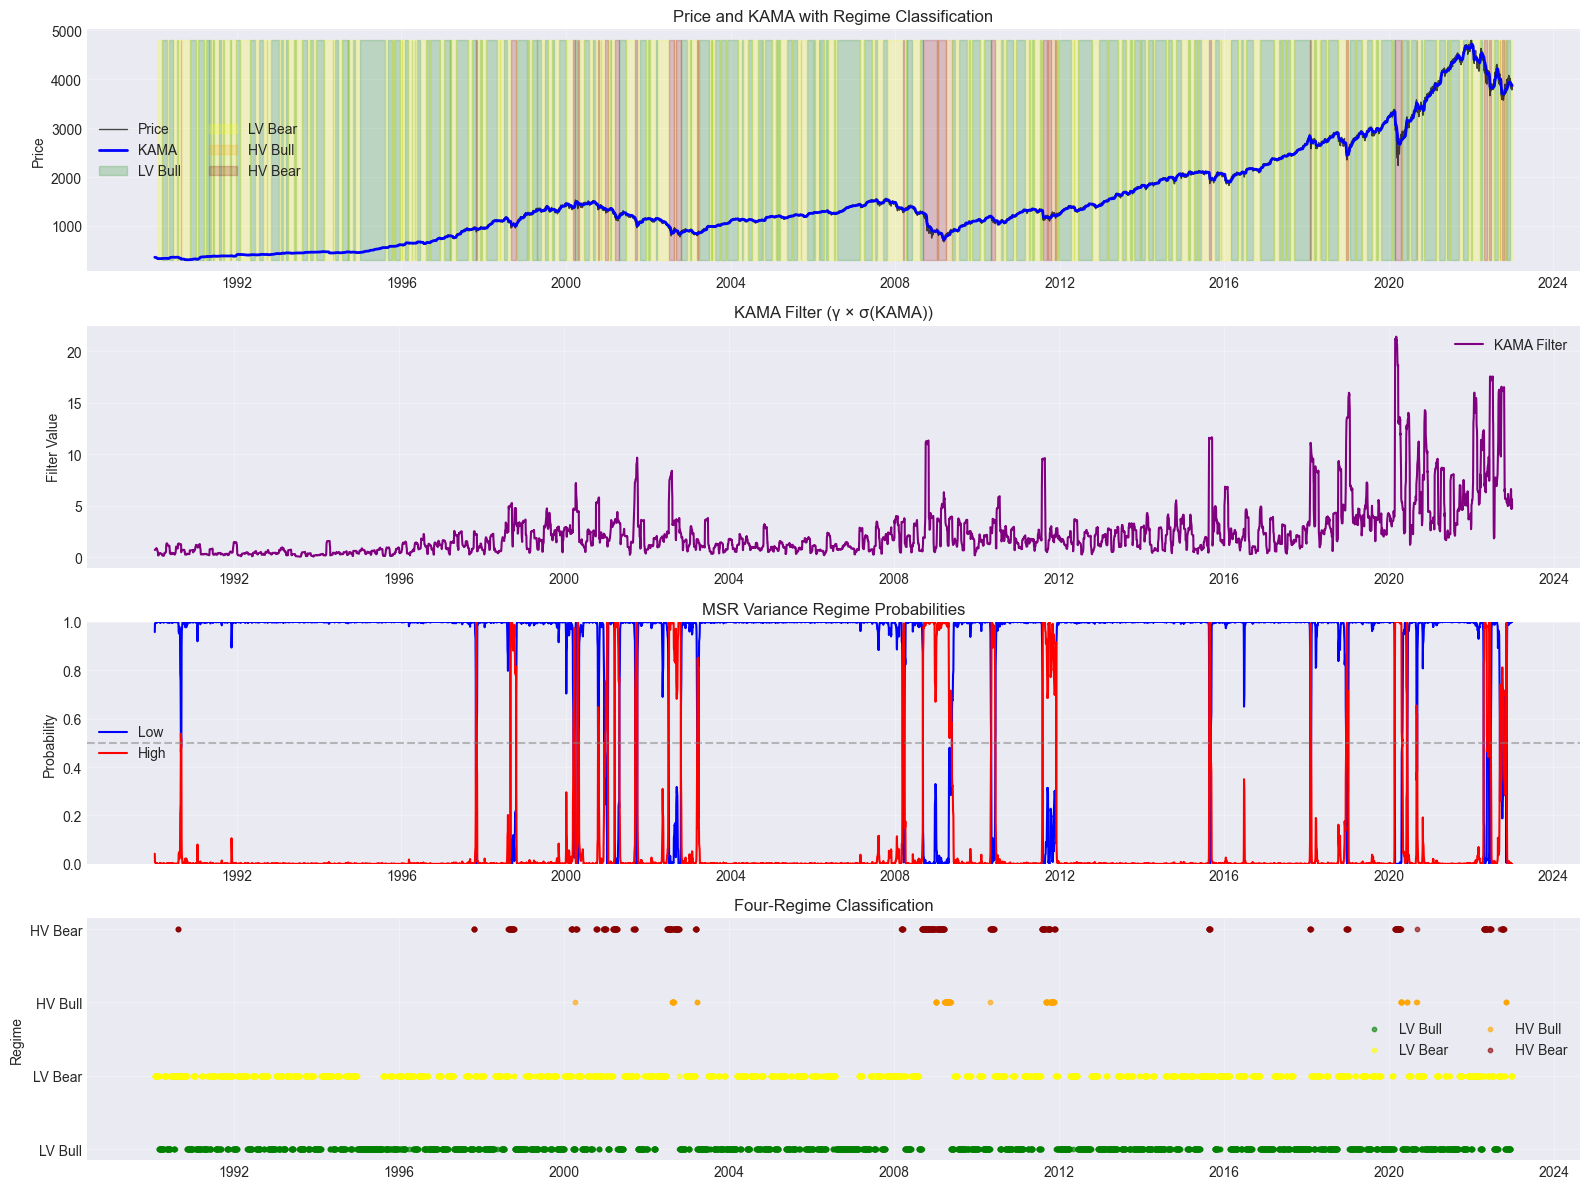

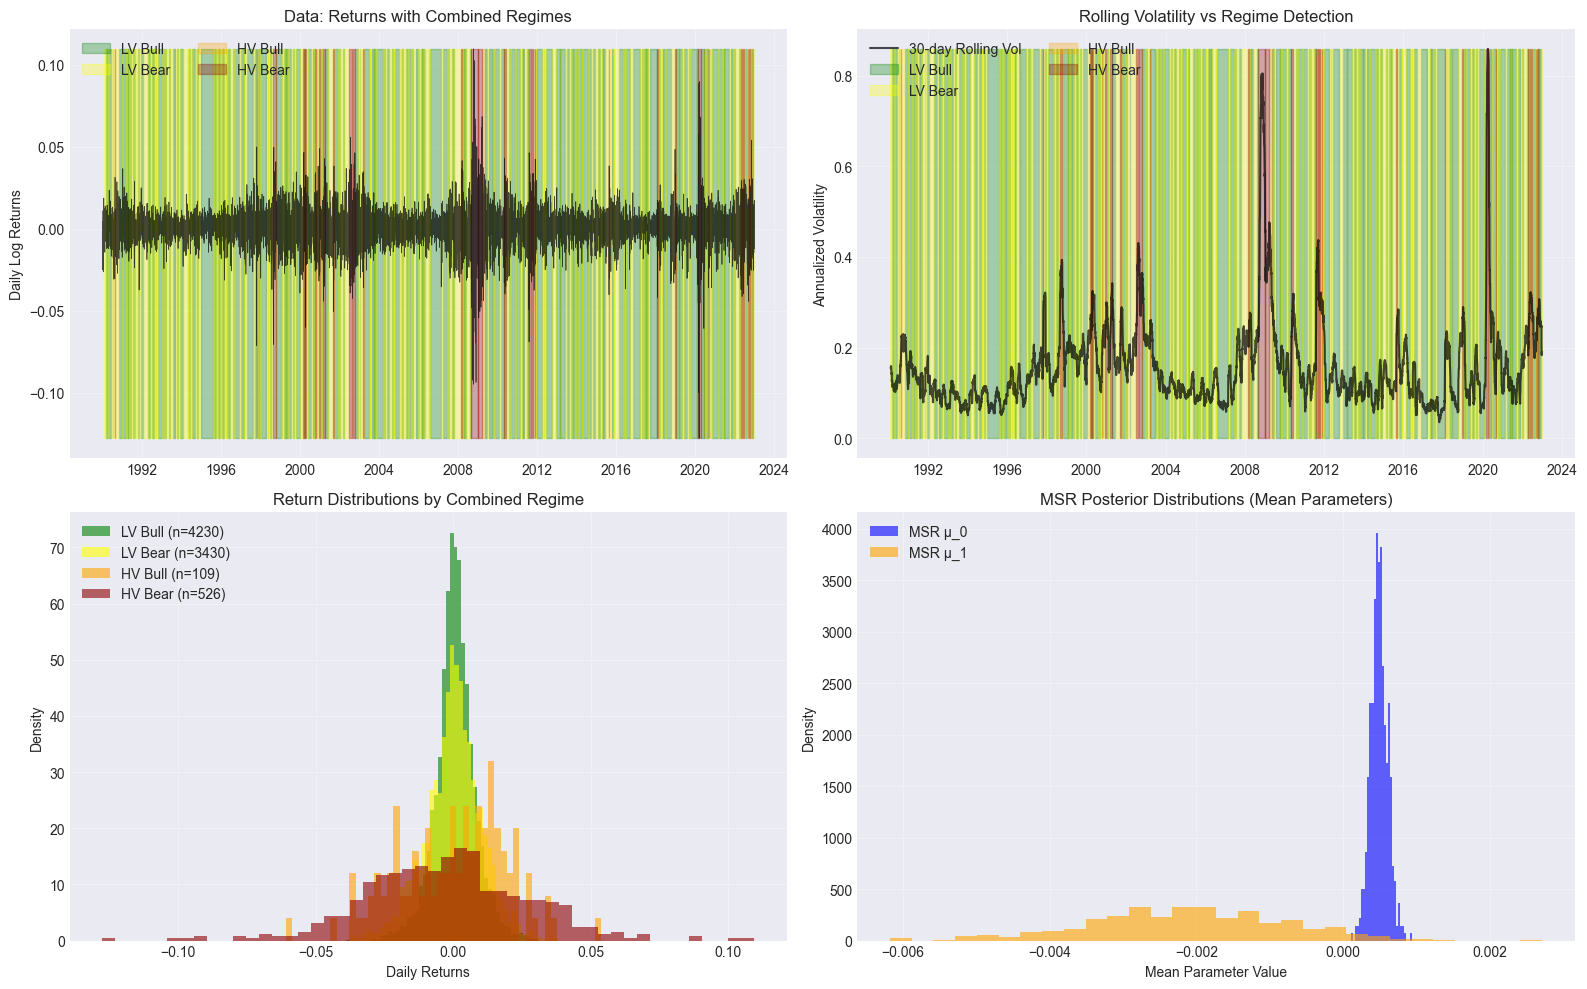

In [9]:
asset_name = 'S&P 500'
n_regimes = 2
sub_folder = 'us_equity'
edte_sub_folder = edte.strftime('%Y%m%d')
load_and_analyze_KAMA_MSR_model(asset_name, n_regimes, sub_folder, edte_sub_folder)